In [53]:
import numpy as np
import  torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import tensorflow as tf

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [55]:
class Block(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
    super(Block, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)

    self.i_downsample = i_downsample
    self.stride = stride
    self.relu = nn.ReLU()

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.i_downsample:
        residual = self.i_downsample(x)
    out += residual
    out = self.relu(out)
    return out


class ResNet_vision(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super(ResNet_vision, self).__init__()
    self.in_channels = in_channels
    self.num_classes = num_classes

    # First convolution layer (assuming you don't need initial processing)
    self.conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    # Stack of 18 residual blocks
    self.blocks = nn.Sequential(*[Block(64,64) for _ in range(18)])

    # Average pooling and fully connected layer
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(64, self.num_classes)  # 4 for output channels after 18 blocks

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)

    x = self.blocks(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)  # flatten
    x = self.fc(x)

    return x


In [56]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
def train2d(model, train_loader, loss_func, optimizer):
    batch_loss = 0.0
    correct = 0
    total = 0
    model.train()  # Set the model to training mode
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        _, predicted_indices = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted_indices == labels).sum().item()

    epoch_loss = batch_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate2d(model, loader, loss_func):
    model.eval()  # Set the model to evaluation mode
    batch_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            batch_loss += loss.item() * inputs.size(0)
            _, predicted_indices = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted_indices == labels).sum().item()

    epoch_loss = batch_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [58]:
# Initialize DataLoader for the test data
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


num_epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []


model_2d = ResNet_vision(3,10).to(device)

loss_func2d = nn.CrossEntropyLoss()
optimizer2d = optim.Adam(model_2d.parameters(), lr=0.0003)

# Training and validation loops
for epoch in range(num_epochs):
    train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
    train_loss, train_acc = train2d(model_2d, train_loader, loss_func2d, optimizer2d)
    val_loss, val_acc = validate2d(model_2d, test_loader, loss_func2d)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/10, Train Loss: 0.0135, Train Acc: 0.3545, Val Loss: 1.4700, Val Acc: 0.4536
Epoch 2/10, Train Loss: 0.0104, Train Acc: 0.5082, Val Loss: 1.2629, Val Acc: 0.5327
Epoch 3/10, Train Loss: 0.0088, Train Acc: 0.5923, Val Loss: 1.0358, Val Acc: 0.6301
Epoch 4/10, Train Loss: 0.0076, Train Acc: 0.6541, Val Loss: 0.9682, Val Acc: 0.6488
Epoch 5/10, Train Loss: 0.0067, Train Acc: 0.6977, Val Loss: 0.8603, Val Acc: 0.6996
Epoch 6/10, Train Loss: 0.0059, Train Acc: 0.7343, Val Loss: 0.7859, Val Acc: 0.7212
Epoch 7/10, Train Loss: 0.0054, Train Acc: 0.7602, Val Loss: 0.7422, Val Acc: 0.7449
Epoch 8/10, Train Loss: 0.0049, Train Acc: 0.7818, Val Loss: 0.7703, Val Acc: 0.7367
Epoch 9/10, Train Loss: 0.0046, Train Acc: 0.7926, Val Loss: 0.7613, Val Acc: 0.7402
Epoch 10/10, Train Loss: 0.0042, Train Acc: 0.8142, Val Loss: 0.7929, Val Acc: 0.7258


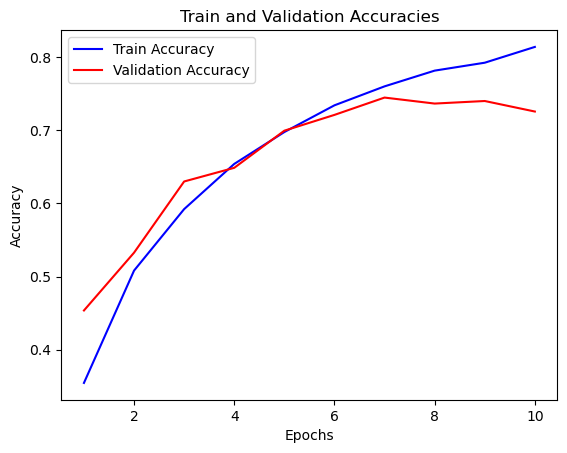

In [59]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
#Saving model parameters
torch.save(model_2d.state_dict(), 'ResNET vision.pt')

In [61]:
#Loading the trained model parameters
model = ResNet_vision(3,10)
model.load_state_dict(torch.load('ResNET vision.pt'))

<All keys matched successfully>